In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from torchmetrics import ConfusionMatrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

import math
import random

from PIL import Image, ImageOps, ImageEnhance
import numbers

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_df = pd.read_csv('./train.csv')

n_train = len(train_df)
n_pixels = len(train_df.columns) - 1
n_class = len(set(train_df['label']))

print('Number of training samples: {0}'.format(n_train))
print('Number of training pixels: {0}'.format(n_pixels))
print('Number of classes: {0}'.format(n_class))

Number of training samples: 42000
Number of training pixels: 784
Number of classes: 10


In [3]:
test_df = pd.read_csv('./test_labeled.csv', sep=';')

n_test = len(test_df)
n_pixels = len(test_df.columns) - 1

print('Number of train samples: {0}'.format(n_test))
print('Number of test pixels: {0}'.format(n_pixels))

Number of train samples: 28000
Number of test pixels: 784


7, 7, 7, 9, 2, 2, 2, 8, 0, 1, 1, 6, 1, 3


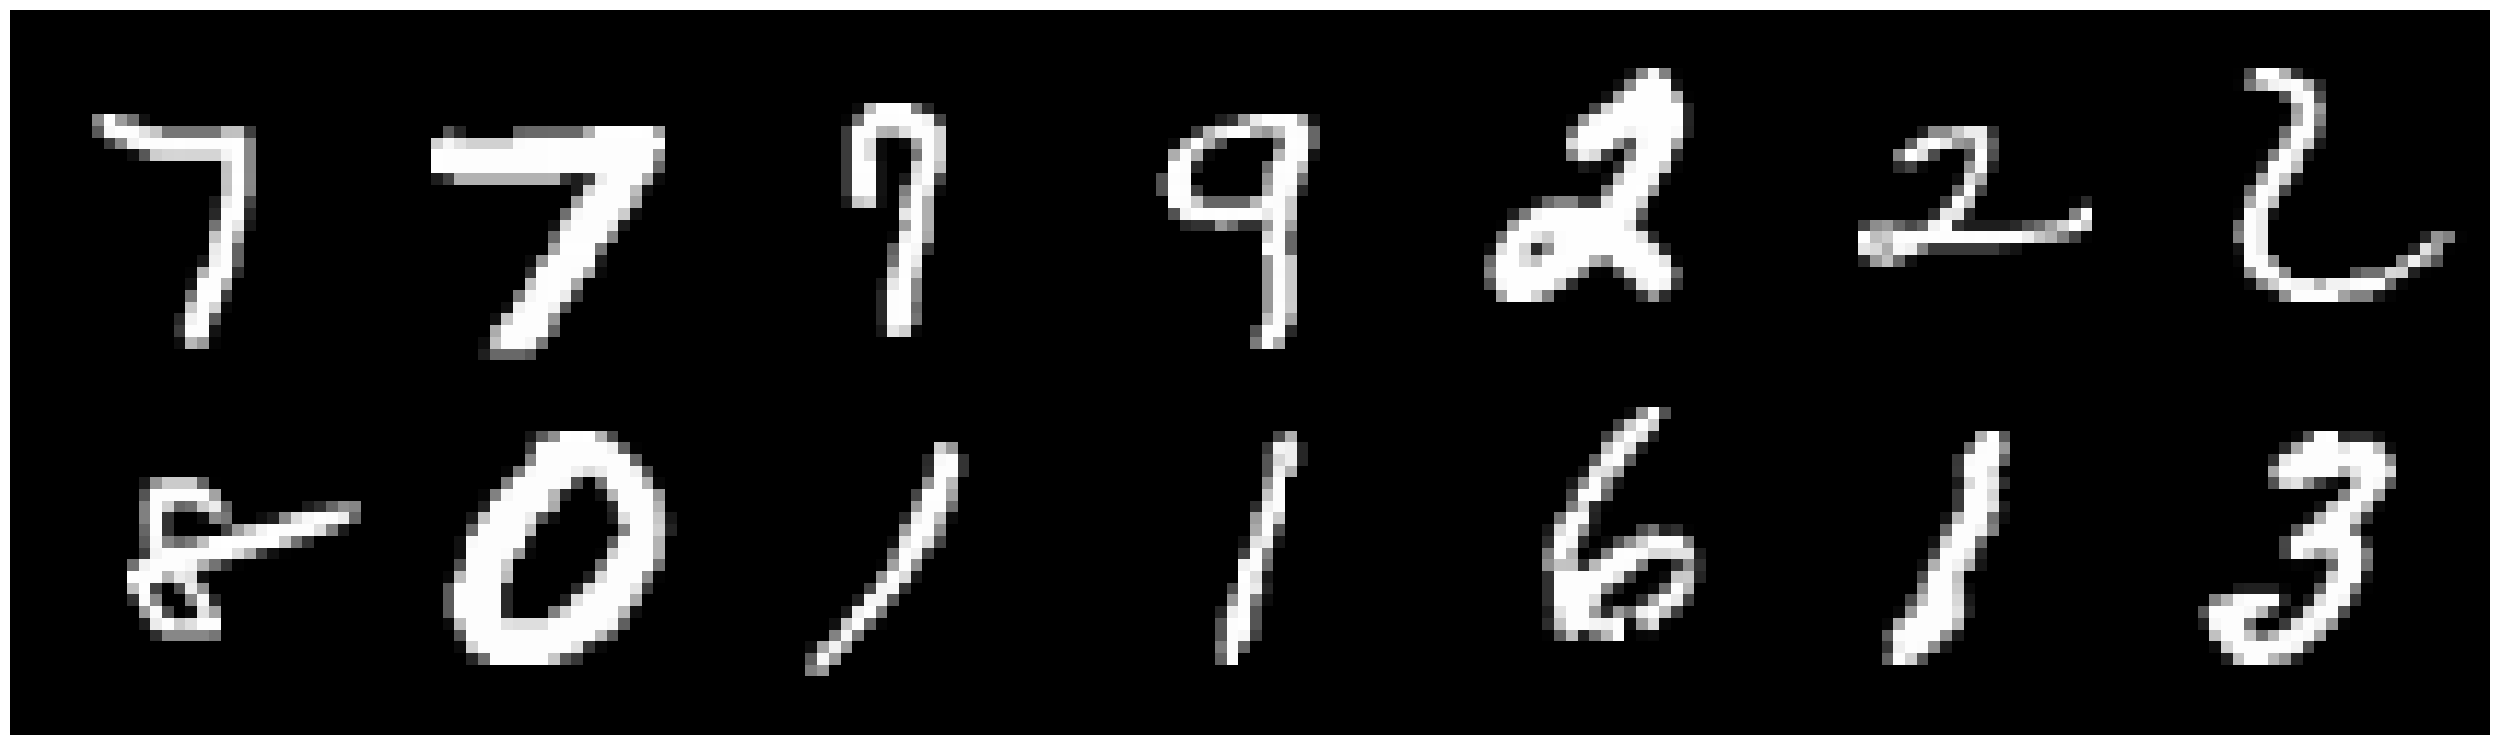

In [4]:
random_sel = np.random.randint(n_train, size=14)

def dispImage(df, row):
    grid = make_grid(torch.Tensor((df.iloc[row, 1:].to_numpy()/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=7)
    plt.rcParams['figure.figsize'] = (32, 150)
    plt.imshow(grid.numpy().transpose((1,2,0)))
    plt.axis('off')

dispImage(train_df, random_sel)
    
print(*list(train_df.iloc[random_sel, 0].values), sep = ', ')

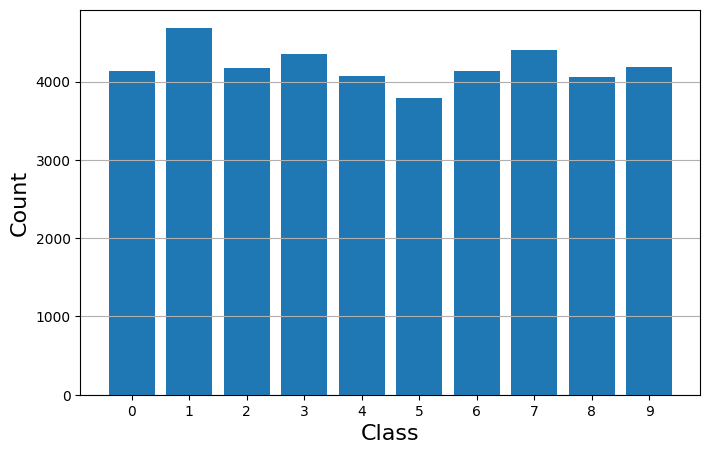

In [5]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.bar(train_df['label'].value_counts().index, train_df['label'].value_counts())
plt.xticks(np.arange(n_class))
plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.grid('on', axis='y')

In [6]:
class MNIST_data(Dataset):
    """MNIST dtaa set"""
    
    
    
    def __init__(self, file_path, sep=',', isTest=False,
                 transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), 
                     transforms.Normalize(mean=(0.5,), std=(0.5,))])
                ):
        
        df = pd.read_csv(file_path, sep=sep)
        self.df = df
        
        if isTest:
            # test data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
            
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def get_labels(self):
        return df.iloc[:,0]

    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

In [7]:
class RandomRotation(object):
    """
    https://github.com/pytorch/vision/tree/master/torchvision/transforms
    Rotate the image by angle.
    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
        resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
        expand (bool, optional): Optional expansion flag.
            If true, expands the output to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
        center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
    """

    def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = np.random.uniform(degrees[0], degrees[1])

        return angle

    def __call__(self, img):
        """
            img (PIL Image): Image to be rotated.
        Returns:
            PIL Image: Rotated image.
        """
        
        def rotate(img, angle, resample=False, expand=False, center=None):
            """Rotate the image by angle and then (optionally) translate it by (n_columns, n_rows)
            Args:
            img (PIL Image): PIL Image to be rotated.
            angle ({float, int}): In degrees degrees counter clockwise order.
            resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
            expand (bool, optional): Optional expansion flag.
            If true, expands the output image to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
            center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
            """
                
            return img.rotate(angle, resample, expand, center)

        angle = self.get_params(self.degrees)

        return rotate(img, angle, self.resample, self.expand, self.center)

In [8]:
class RandomShift(object):
    def __init__(self, shift):
        self.shift = shift
        
    @staticmethod
    def get_params(shift):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        hshift, vshift = np.random.uniform(-shift, shift, size=2)

        return hshift, vshift 
    def __call__(self, img):
        hshift, vshift = self.get_params(self.shift)
        
        return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)
    

In [9]:
batch_size = 64

train_dataset = MNIST_data('./train.csv', transform= transforms.Compose(
                            [transforms.ToPILImage(), RandomRotation(degrees=20), RandomShift(3),
                             transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))]))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True)




test_dataset = MNIST_data('./test_labeled.csv', sep=';', isTest=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, shuffle=False)

train_x_dataset = MNIST_data('./train.csv', isTest=True)
train_x_loader = torch.utils.data.DataLoader(dataset=train_x_dataset, batch_size=batch_size, shuffle=False)


test_y_dataset = MNIST_data('./test_labeled.csv', sep=';')
test_y_loader = torch.utils.data.DataLoader(dataset=test_y_dataset, batch_size=batch_size, shuffle=True)


1, 0, 1, 4, 0, 0, 7, 3, 5, 3
1, 0, 1, 4, 0, 0, 7, 3, 5, 3


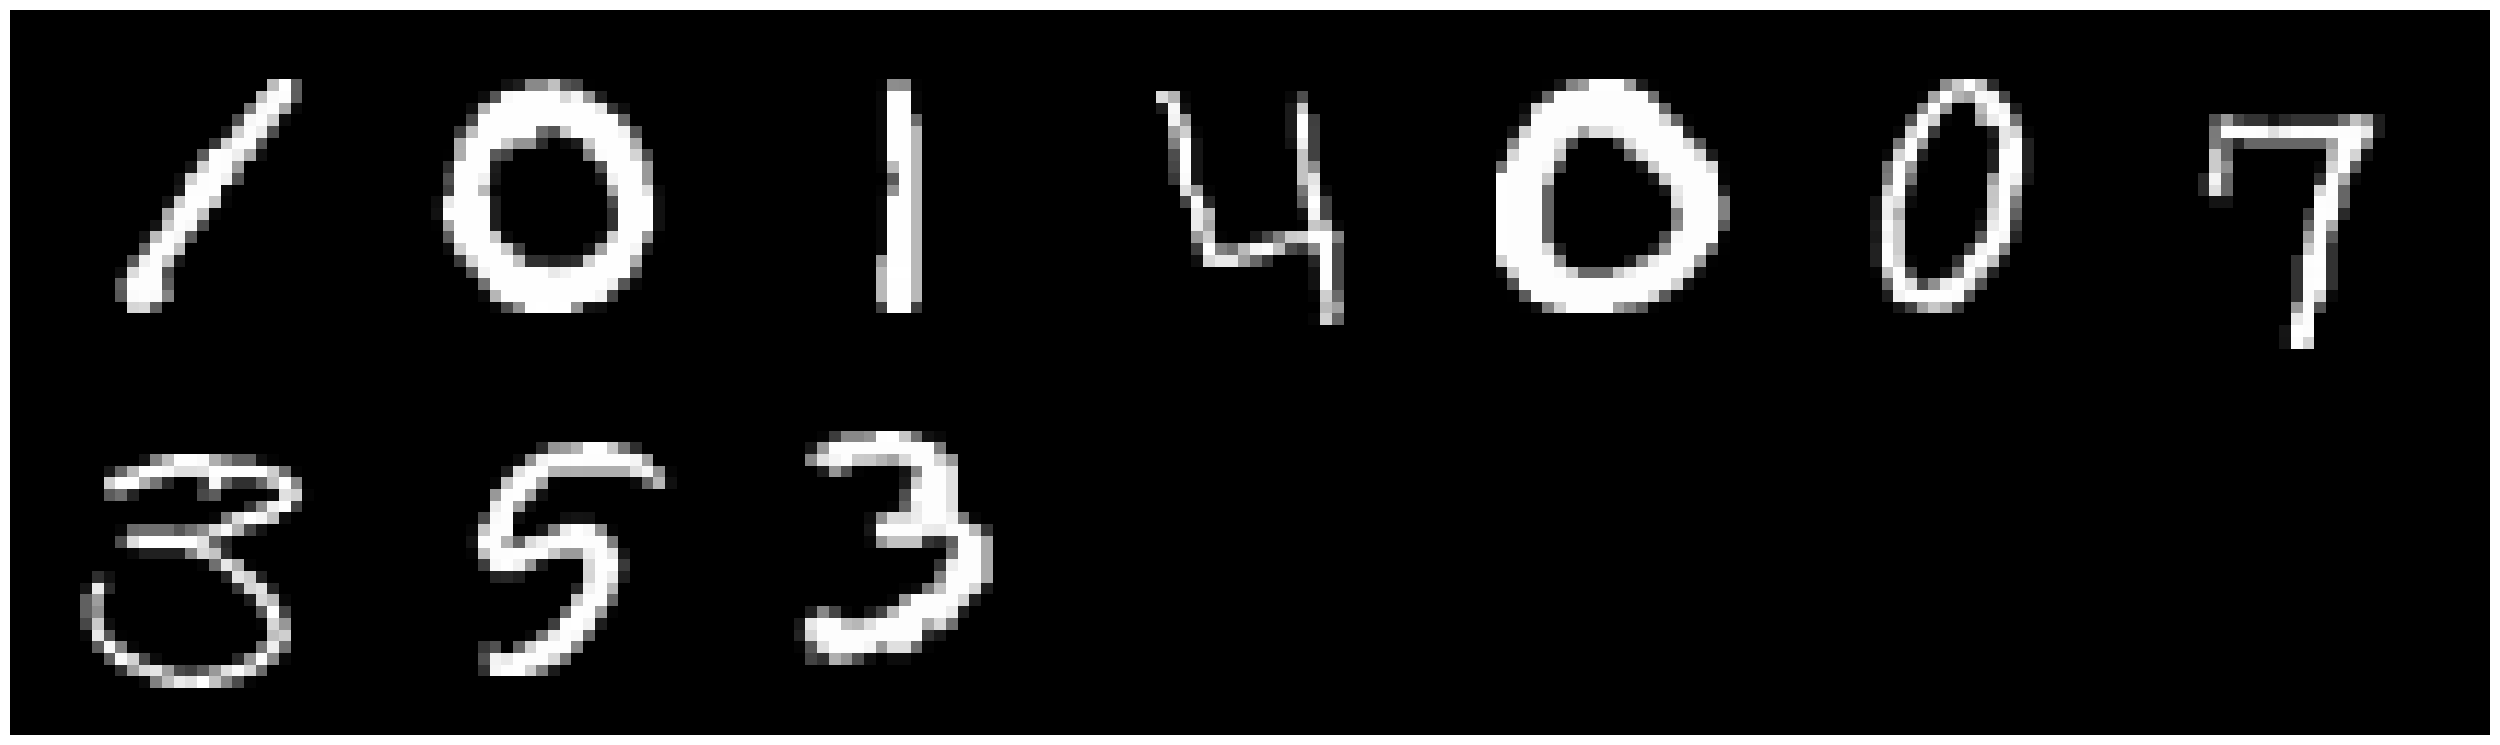

In [10]:
dispImage(train_df, np.arange(10))
    
print(*list(train_df.iloc[:10, 0].values), sep = ', ')
print(*list(train_dataset.df.iloc[:10,0].values), sep = ', ')

/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_3135/2105636642.py:17: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
  return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)
/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_3135/2105636642.py:17: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)


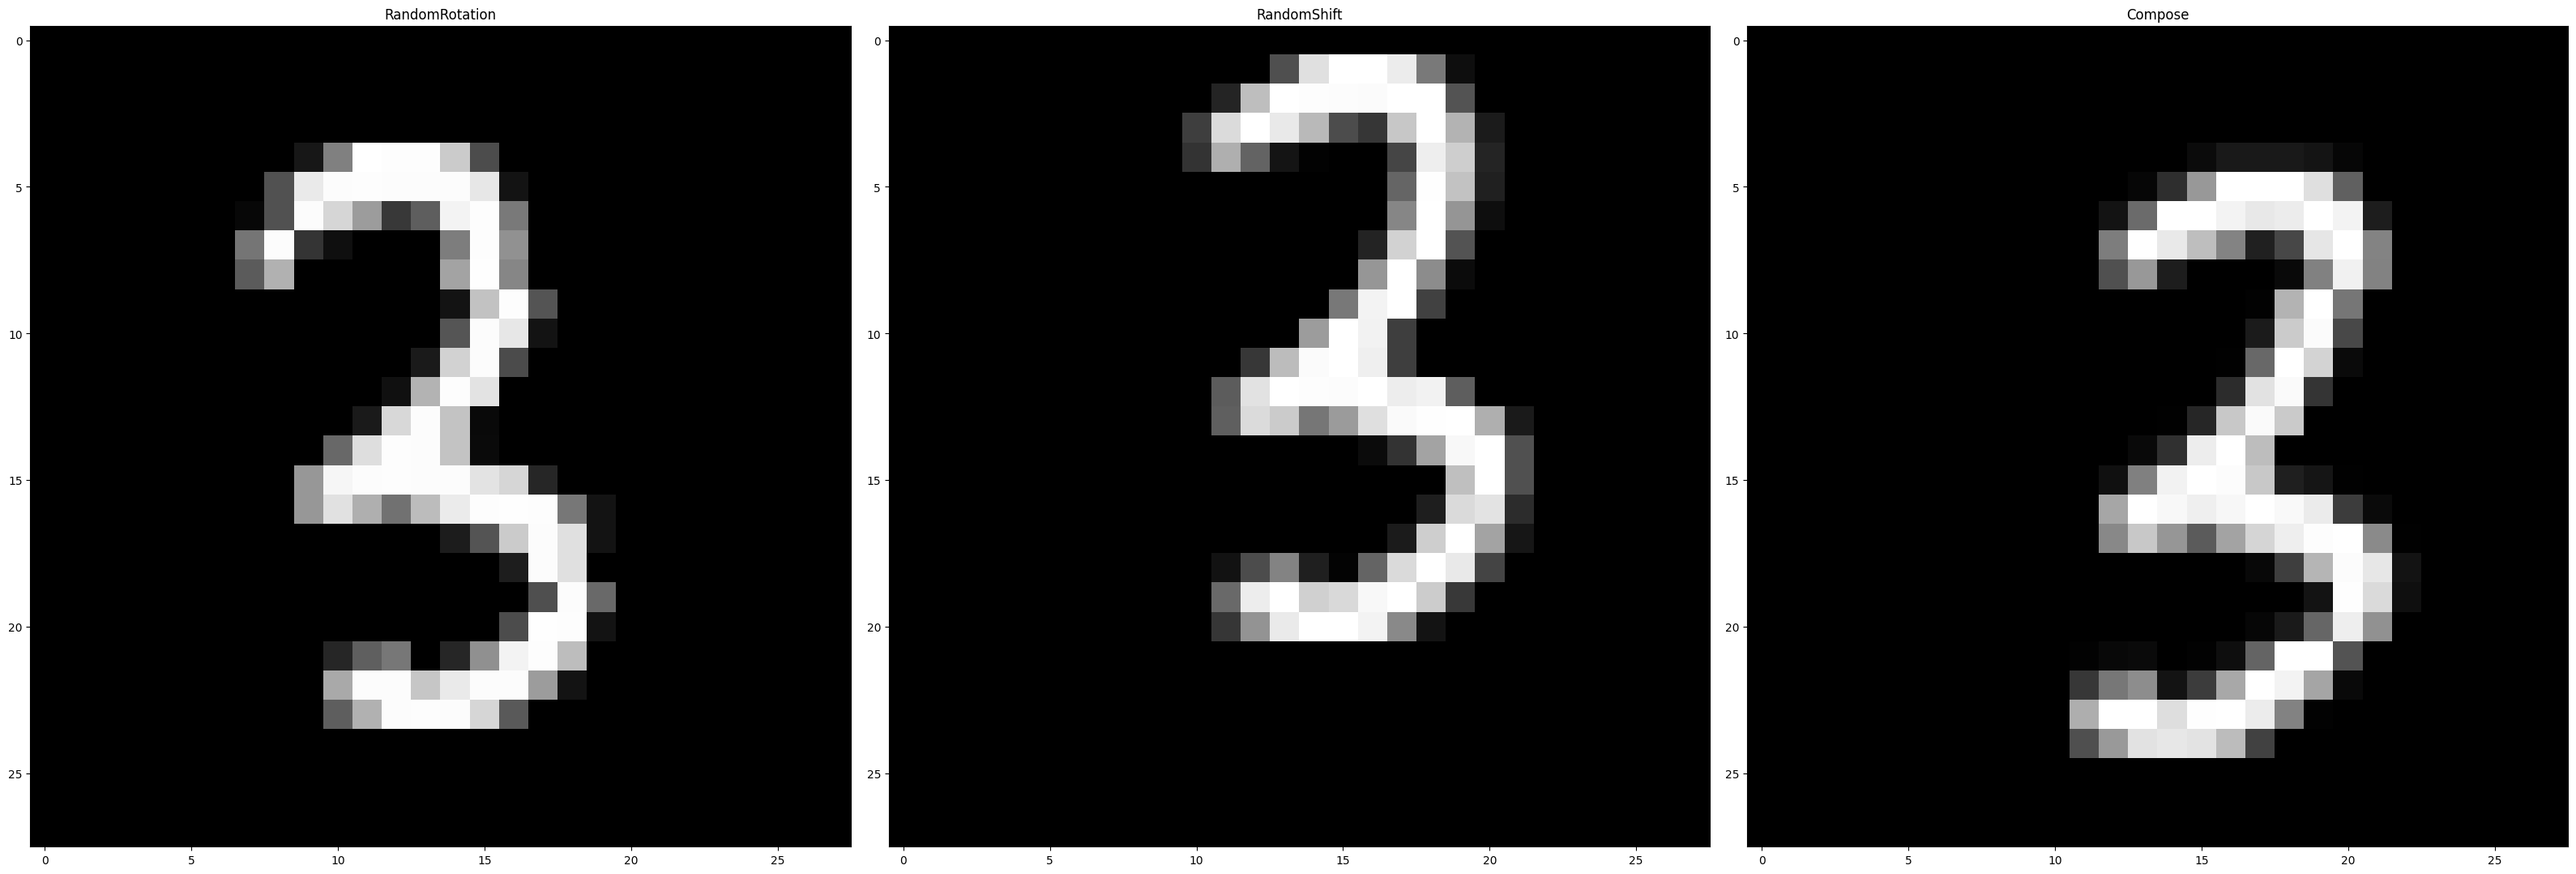

In [11]:
rotate = RandomRotation(20)
shift = RandomShift(3)
composed = transforms.Compose([RandomRotation(20),
                               RandomShift(3)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = transforms.ToPILImage()(train_df.iloc[65,1:].values.reshape((28,28)).astype(np.uint8)[:,:,None])
for i, tsfrm in enumerate([rotate, shift, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    ax.imshow(np.reshape(np.array(list(transformed_sample.getdata())), (-1,28)), cmap='gray')    

plt.show()

In [12]:
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
          
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )
          
        for m in self.features.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x     

In [13]:
model = Net()

optimizer = optim.Adam(model.parameters(), lr=0.003)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_3135/4122321177.py:45: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


In [14]:
loss_values = []
def train(epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        val = F.cross_entropy(output, target, size_average=False).data
        loss_values.append(val)
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data))
    
    
    exp_lr_scheduler.step()

In [15]:
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data, target = Variable(data), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).data

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

In [16]:
n_epochs = 1

for epoch in range(n_epochs):
    train(epoch)
    evaluate(train_loader)

/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_3135/2105636642.py:17: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
  return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)
/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_3135/2105636642.py:17: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)
/Users/ilerisoy/opt/anaconda3/envs/ml/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 0 [6400/42000 (15%)]	Loss: 0.350542
Train Epoch: 0 [12800/42000 (30%)]	Loss: 0.413865
Train Epoch: 0 [19200/42000 (46%)]	Loss: 0.159347
Train Epoch: 0 [25600/42000 (61%)]	Loss: 0.358994
Train Epoch: 0 [32000/42000 (76%)]	Loss: 0.597636
Train Epoch: 0 [38400/42000 (91%)]	Loss: 0.151877

Average loss: 0.1045, Accuracy: 40637/42000 (96.755%)



[tensor(216.7884), tensor(184.3560), tensor(187.6188), tensor(158.7614), tensor(149.5475)] [tensor(5.5059), tensor(15.5985), tensor(11.1276), tensor(5.7450), tensor(2.5066)]


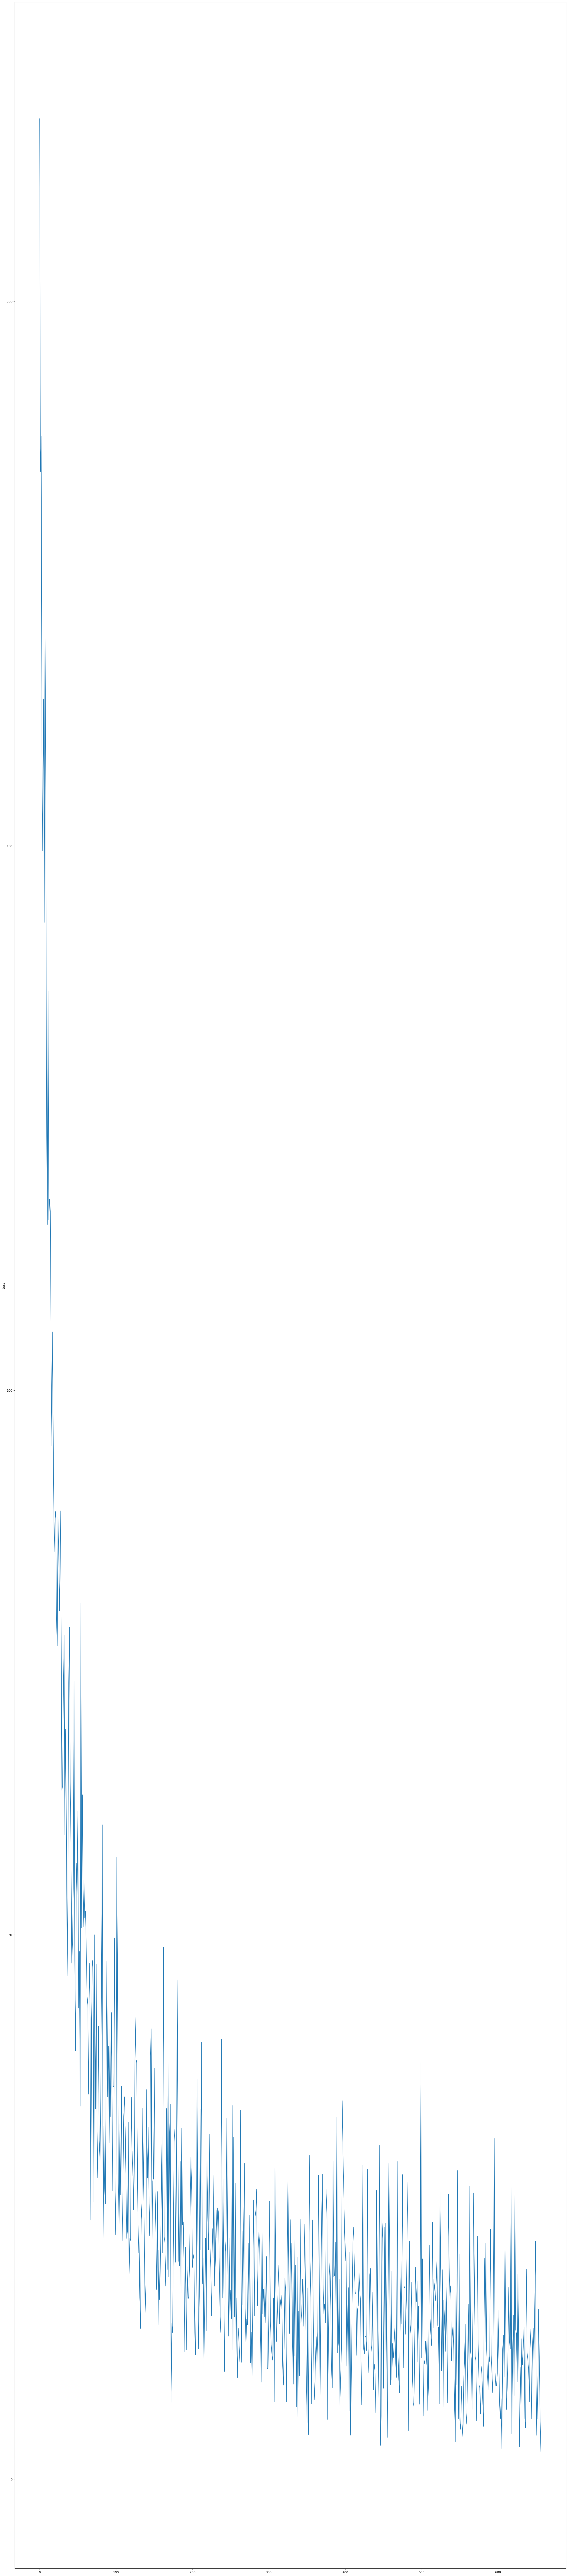

In [28]:
print(loss_values[0:5], loss_values[len(loss_values)-5:] )
plt.plot(loss_values)
plt.ylabel('Loss')
plt.show()

In [18]:
def prediciton(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = Variable(data)
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = model(data)
        
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

In [19]:
train_pred = prediciton(train_x_loader)

In [20]:
train_prediction_df = pd.DataFrame(np.c_[np.arange(1, len(train_dataset)+1)[:,None], train_pred.numpy()], 
                      columns=['ImageId', 'Label'])

# Make a numpay array by predcited labels
train_predictions = train_prediction_df.iloc[:,1].to_numpy()
train_labels = train_df.iloc[:,0].to_numpy()
print(len(train_predictions), train_predictions[:10], train_labels[:10])

42000 [1 0 1 4 0 0 7 3 5 3] [1 0 1 4 0 0 7 3 5 3]


In [21]:
train_predictions = train_prediction_df.iloc[:, 1].to_numpy()

count = 0
train_index = []

for i in range(len(train_predictions)):
    if train_dataset.df.iloc[i,0] == train_predictions[i]:
        continue
    else:
        count +=1
        train_index.append(i)
        print("Label is: ", train_dataset.y.numpy()[i], "Predcition is: ", train_predictions[i], "index is: ", i)
print(count)

Label is:  9 Predcition is:  8 index is:  40
Label is:  4 Predcition is:  9 index is:  43
Label is:  2 Predcition is:  3 index is:  73
Label is:  5 Predcition is:  8 index is:  125
Label is:  0 Predcition is:  8 index is:  149
Label is:  2 Predcition is:  3 index is:  190
Label is:  0 Predcition is:  8 index is:  251
Label is:  4 Predcition is:  8 index is:  291
Label is:  5 Predcition is:  9 index is:  453
Label is:  7 Predcition is:  9 index is:  504
Label is:  4 Predcition is:  1 index is:  516
Label is:  4 Predcition is:  6 index is:  548
Label is:  1 Predcition is:  2 index is:  622
Label is:  9 Predcition is:  0 index is:  641
Label is:  2 Predcition is:  7 index is:  644
Label is:  5 Predcition is:  9 index is:  686
Label is:  2 Predcition is:  7 index is:  719
Label is:  9 Predcition is:  8 index is:  799
Label is:  1 Predcition is:  8 index is:  897
Label is:  0 Predcition is:  8 index is:  976
Label is:  4 Predcition is:  9 index is:  1004
Label is:  4 Predcition is:  9 index

Label is:  5 Predcition is:  3 index is:  10328
Label is:  2 Predcition is:  8 index is:  10436
Label is:  4 Predcition is:  9 index is:  10455
Label is:  5 Predcition is:  8 index is:  10555
Label is:  2 Predcition is:  3 index is:  10644
Label is:  7 Predcition is:  9 index is:  10692
Label is:  8 Predcition is:  9 index is:  10712
Label is:  5 Predcition is:  6 index is:  10803
Label is:  0 Predcition is:  8 index is:  10808
Label is:  2 Predcition is:  3 index is:  10819
Label is:  4 Predcition is:  9 index is:  10910
Label is:  0 Predcition is:  8 index is:  10961
Label is:  5 Predcition is:  9 index is:  11037
Label is:  1 Predcition is:  7 index is:  11246
Label is:  0 Predcition is:  8 index is:  11303
Label is:  8 Predcition is:  9 index is:  11340
Label is:  1 Predcition is:  7 index is:  11406
Label is:  4 Predcition is:  9 index is:  11459
Label is:  5 Predcition is:  9 index is:  11509
Label is:  4 Predcition is:  6 index is:  11564
Label is:  5 Predcition is:  0 index is:

Label is:  3 Predcition is:  8 index is:  21815
Label is:  4 Predcition is:  8 index is:  21841
Label is:  2 Predcition is:  3 index is:  21940
Label is:  0 Predcition is:  8 index is:  21942
Label is:  0 Predcition is:  8 index is:  22002
Label is:  3 Predcition is:  7 index is:  22054
Label is:  7 Predcition is:  4 index is:  22134
Label is:  1 Predcition is:  6 index is:  22199
Label is:  4 Predcition is:  9 index is:  22202
Label is:  3 Predcition is:  9 index is:  22213
Label is:  3 Predcition is:  8 index is:  22336
Label is:  3 Predcition is:  2 index is:  22368
Label is:  4 Predcition is:  9 index is:  22372
Label is:  8 Predcition is:  9 index is:  22558
Label is:  0 Predcition is:  8 index is:  22592
Label is:  0 Predcition is:  6 index is:  22698
Label is:  3 Predcition is:  8 index is:  22825
Label is:  2 Predcition is:  8 index is:  22828
Label is:  0 Predcition is:  5 index is:  22833
Label is:  8 Predcition is:  9 index is:  22888
Label is:  7 Predcition is:  9 index is:

Label is:  3 Predcition is:  8 index is:  33356
Label is:  0 Predcition is:  8 index is:  33434
Label is:  0 Predcition is:  8 index is:  33516
Label is:  7 Predcition is:  3 index is:  33574
Label is:  9 Predcition is:  7 index is:  33675
Label is:  7 Predcition is:  8 index is:  33760
Label is:  3 Predcition is:  5 index is:  33762
Label is:  7 Predcition is:  9 index is:  33855
Label is:  4 Predcition is:  9 index is:  33952
Label is:  9 Predcition is:  4 index is:  34117
Label is:  9 Predcition is:  4 index is:  34274
Label is:  1 Predcition is:  2 index is:  34454
Label is:  0 Predcition is:  8 index is:  34463
Label is:  0 Predcition is:  6 index is:  34578
Label is:  7 Predcition is:  3 index is:  34590
Label is:  7 Predcition is:  9 index is:  34599
Label is:  1 Predcition is:  5 index is:  34751
Label is:  2 Predcition is:  8 index is:  34807
Label is:  0 Predcition is:  6 index is:  34897
Label is:  0 Predcition is:  8 index is:  34904
Label is:  0 Predcition is:  6 index is:

In [22]:
print(train_dataset.y.numpy()[:5])

[1 0 1 4 0]


In [23]:
con_train = confusion_matrix(train_dataset.df.iloc[:,0], train_predictions)
# Confusion matrix whose i-th row and j-th column entry indicates the number of samples with 
# true label being i-th class and predicted label being j-th class.
print("\nConfusion Matrix is:\n")
print(con_train,"\n")


Confusion Matrix is:

[[4016    0    4    0    0    1   30    0   71   10]
 [   0 4620   26    8    2    2    1   20    5    0]
 [   0    5 4062   21    3    0    0   41   44    1]
 [   2    1    5 4284    0   13    0    9   28    9]
 [   0    5    2    1 3978    0   13    1    8   64]
 [   2    2    0    3    2 3725   29    1   20   11]
 [   4    5    1    1    3    6 4106    0   11    0]
 [   0    1   21    7    8    0    0 4326   11   27]
 [   1    2    7    1    7    3    5    3 4014   20]
 [   4    3    0    1   15    2    0   17   35 4111]] 



In [24]:
test_pred = prediciton(test_loader)

In [25]:
test_pred_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], test_pred.numpy()], 
                      columns=['ImageId', 'Label'])

In [26]:
test_pred_df.head(10)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


In [27]:
test_predictions = test_pred_df.iloc[:, 1].to_numpy()
con_test = confusion_matrix(test_dataset.df.iloc[:,0], test_predictions)
# Confusion matrix whose i-th row and j-th column entry indicates the number of samples with 
# true label being i-th class and predicted label being j-th class.
print("\nConfusion Matrix is:\n")
print(con_test,"\n")


Confusion Matrix is:

[[2679    0    8    0    0    1   17    0   77    2]
 [   0 3139    3    2    2    4   14    9    7    1]
 [   0    5 2687    4    0    0    0    3   30    0]
 [   1    2    5 2750    0    8    0    3   40   16]
 [   0    0   14    1 2704    0   17    0   21   40]
 [   2    1    0    3    0 2439   11    0   14   16]
 [   3    1    0    0    0   26 2709    0   27    1]
 [   1    1   80   19   18    2    0 2864   19   55]
 [   0    0    1    0    0    0    2    0 2594    4]
 [   0    0    1    0    3    1    1    3   79 2683]] 

